In [1]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
import re
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from collections import OrderedDict
import copy
import pickle
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cloudpickle
from contextlib import contextmanager

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

/home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@contextmanager
def custom_torch_load(map_location):
    original_torch_load = torch.load

    def custom_load(*args, **kwargs):
        kwargs['map_location'] = map_location
        return original_torch_load(*args, **kwargs)

    torch.load = custom_load
    try:
        yield
    finally:
        torch.load = original_torch_load

In [3]:
import gc
gc.collect()

56

In [4]:
map_location = 'cuda:0'

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
client = Client(n_workers=100) #128 totally

In [28]:
config = yaml.safe_load(open('../config.yaml'))

In [8]:
print(torch.__version__, torch.cuda.is_available())

2.0.1+cu118 True


In [55]:
# torch.cuda.set_device(0)

# Coord

In [9]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])

In [10]:
static_gdf = coord_gdf[['x', 'y', 'channel', 'ter', 'geometry']]
static_gdf

,x,y,channel,ter,geometry
0,2.933766e+06,1.396557e+07,0,301.388702,"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,0,301.594696,"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,0,294.629181,"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,0,298.529877,"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,0,294.815002,"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,1,54.643570,"POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,1,59.625050,"POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,0,60.055576,"POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,0,59.625050,"POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [11]:
coord_union_gdf = gpd.GeoDataFrame(geometry=[coord_gdf.unary_union], crs=coord_gdf.crs)

# Real events

In [13]:
np.random.seed(3)
sample_event_num = 50
event_indices = np.random.choice(range(593), sample_event_num, replace=False)
event_indices

array([349, 402,  37, 345, 340, 375, 134, 268, 535,  10,  53, 161, 513,
       247, 107, 410, 428, 192, 362, 450, 378,  14, 280,  58, 312, 323,
       237, 438, 467,  48, 288, 328, 130, 137, 131, 239,  45, 194, 592,
       127, 102, 448, 488, 522, 124, 575, 492, 315, 132, 524])

In [14]:
scaler = MinMaxScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']]
    if scale:
        df[['x', 'y']] = xy_scaled
    return df
file_paths = [f'../src/tables/data{i}.parquet' for i in event_indices]
selected_events = [load_and_scale(file, scale=True) for file in file_paths]
with ProgressBar():
    result = dpd.concat(selected_events, axis=0)
selected_events_df = result.compute()
selected_events_df = selected_events_df.drop(columns=['channel', 'ter', 'depth']).reset_index(drop=True)

# Depth model

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_heads=8, num_layers=4, transform_dim=128):
        super(TransformerModel, self).__init__()
        self.input_transform = nn.Linear(input_dim, transform_dim)

        # Transformer specific layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=transform_dim, 
            nhead=num_heads,
            dim_feedforward=2048,  
            dropout=0.25  
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Output layer
        self.fc_out = nn.Linear(transform_dim, output_dim)

    def forward(self, src):
        src = self.input_transform(src)
        transformed = self.transformer_encoder(src)
        output = self.fc_out(transformed)
        return output

In [16]:
device = torch.device('cuda:0')

In [17]:
model = TransformerModel(5).to(device)

In [18]:
tf_checkpoint = torch.load('../checkpoints/depth/best_model_0_1e-05.pth', map_location='cuda:0')

In [19]:
new_state_dict = OrderedDict()
for k, v in tf_checkpoint.items():
    # Remove 'module.' prefix
    name = k[7:]  # skip 'module.' (7 characters)
    new_state_dict[name] = v

# Load the adjusted state dict into your model
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [21]:
selected_events_df['duration'] = selected_events_df['duration'].astype(float)

# cCTGAN

In [22]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(selected_events_df)

In [23]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "x": {
            "sdtype": "numerical"
        },
        "y": {
            "sdtype": "numerical"
        },
        "cumu_rain": {
            "sdtype": "numerical"
        },
        "peak_int": {
            "sdtype": "numerical"
        },
        "duration": {
            "sdtype": "numerical"
        }
    }
}

In [31]:
def filter_rows_by_condition(df):
    return df[(df['peak_int'] > df['cumu_rain'] / df['duration']) & (df['cumu_rain'] > df['peak_int'])]

In [37]:
lr_sets = config['gan_lr_sets']
# filtered_res_df = pd.DataFrame(columns=['G_LR', 'D_LR', 'Epochs', 'rows', 'Effective Column Shapes'])
for lrs in tqdm(lr_sets, total=len(lr_sets)):
    for epoch in tqdm(range(50, config['gan_epochs']+1, 50), desc=f'{lrs[0]:.0e}_{lrs[1]:.0e}', total=len(range(50, config['gan_epochs']+1, 50))):
        filtered_df_path = f'../outputs/augmented_data/{lrs[0]:.0e}_{lrs[1]:.0e}_{epoch}.parquet'
        ctgan_synthetic_inbound_df = pd.read_parquet(filtered_df_path)
        ctgan_synthetic_inbound_df = filter_rows_by_condition(ctgan_synthetic_inbound_df).reset_index(drop=True)
        ctgan_synthetic_inbound_df.to_parquet(filtered_df_path)
        # if not os.path.exists(filtered_df_path):
        #     with custom_torch_load(map_location):
        #         ctgan_synthesizer = CTGANSynthesizer.load(filepath=f'../checkpoints/cCTGAN/{lrs[0]}_{lrs[1]}_{epoch}.pkl')
        #     print('Generating events...')
        #     ctgan_synthetic_df = ctgan_synthesizer.sample(num_rows=5000000)
        #     ctgan_synthetic_df[['x', 'y']] = scaler.inverse_transform(ctgan_synthetic_df[['x', 'y']])
        #     ctgan_synthetic_gdf = gpd.GeoDataFrame(
        #         ctgan_synthetic_df, 
        #         geometry=gpd.points_from_xy(ctgan_synthetic_df.x, ctgan_synthetic_df.y),
        #         crs=coord_gdf.crs
        #     )
        #     print('Filtering...')
        #     ctgan_synthetic_inbound_df = ctgan_synthetic_gdf.sjoin(coord_union_gdf, predicate='within').drop(columns=['geometry', 'index_right'])
        #     ctgan_synthetic_inbound_df = filter_rows_by_condition(ctgan_synthetic_inbound_df).reset_index(drop=True)
        #     ctgan_synthetic_inbound_df.to_parquet(filtered_df_path)
        # else:
        #     ctgan_synthetic_inbound_df = pd.read_parquet(filtered_df_path)
        #     ctgan_synthetic_inbound_df = filter_rows_by_condition(ctgan_synthetic_inbound_df).reset_index(drop=True)
        #     ctgan_synthetic_inbound_df.to_parquet(filtered_df_path)
        # quality_report = evaluate_quality(
        #     real_data=selected_events_df,
        #     synthetic_data=ctgan_synthetic_inbound_df,
        #     metadata=metadata, verbose=False)
        # q_res = dict(zip(filtered_res_df.columns, [lrs[0], lrs[1], epoch, len(ctgan_synthetic_inbound_df), quality_report.get_details(property_name='Column Shapes').iloc[2:]['Score'].mean()]))
        # filtered_res_df.loc[len(filtered_res_df)] = q_res
        # print(q_res)

100%|██████████| 6/6 [01:42<00:00, 17.00s/it]


In [33]:
filtered_res_df

,G_LR,D_LR,Epochs,rows,Effective Column Shapes
0,0.00001,0.00001,50,6252881,0.831061
1,0.00001,0.00001,100,6384850,0.798789
2,0.00001,0.00001,150,6610860,0.830541
3,0.00001,0.00001,200,6284145,0.799550
4,0.00001,0.00001,250,6717617,0.809364
5,0.00001,0.00001,300,7017898,0.860295
6,0.00002,0.00001,50,6310021,0.823094
7,0.00002,0.00001,100,6669922,0.824538
8,0.00002,0.00001,150,6644716,0.817557
9,0.00002,0.00001,200,6511748,0.850106


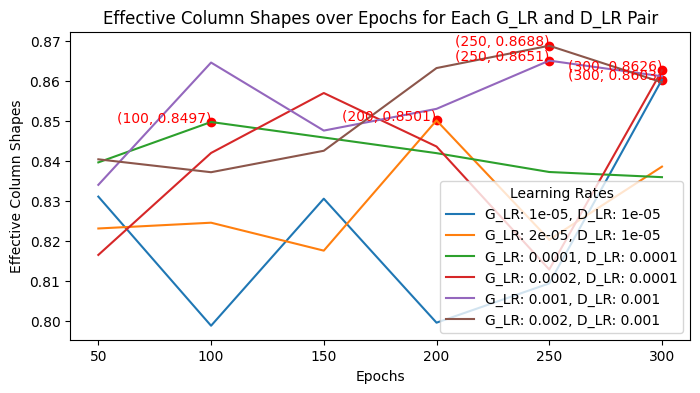

In [34]:
# Group by G_LR and D_LR
grouped = filtered_res_df.groupby(['G_LR', 'D_LR'])

# Plot
plt.figure(figsize=(8, 4))
for (g_lr, d_lr), group in grouped:
    sns.lineplot(x='Epochs', y='Effective Column Shapes', data=group, label=f'G_LR: {g_lr}, D_LR: {d_lr}')

    # Find the max Effective Column Shapes point
    max_row = group.loc[group['Effective Column Shapes'].idxmax()]
    max_epoch = max_row['Epochs']
    max_shape = max_row['Effective Column Shapes']

    # Highlight and annotate the max point
    plt.scatter(max_epoch, max_shape, color='red')
    plt.text(max_epoch, max_shape, f'({int(max_epoch)}, {round(max_shape, 4)})', color='red', ha='right')

plt.xlabel('Epochs')
plt.ylabel('Effective Column Shapes')
plt.title('Effective Column Shapes over Epochs for Each G_LR and D_LR Pair')
plt.legend(title='Learning Rates', loc='lower right')
plt.show()

In [42]:
ctgan_synthetic_df = pd.read_parquet(f'../outputs/augmented_data/2e-03_1e-03_250.parquet')
ctgan_synthetic_gdf = gpd.GeoDataFrame(
    ctgan_synthetic_df, 
    geometry=gpd.points_from_xy(ctgan_synthetic_df.x, ctgan_synthetic_df.y),
    crs=coord_gdf.crs
)

In [43]:
ctgan_synthetic_gdf

,x,y,cumu_rain,peak_int,duration,geometry
0,2.959775e+06,1.387102e+07,0.183705,0.158535,3.0,POINT (2959775.183 13871019.799)
1,3.020091e+06,1.390189e+07,12.574293,2.572523,10.0,POINT (3020091.137 13901888.503)
2,3.135043e+06,1.384402e+07,16.448829,12.156572,4.0,POINT (3135043.250 13844017.376)
3,2.982755e+06,1.393181e+07,7.201126,6.472757,3.0,POINT (2982754.942 13931810.605)
4,2.973009e+06,1.394492e+07,0.455556,0.402246,3.0,POINT (2973009.371 13944917.607)
...,...,...,...,...,...,...
7017240,3.064488e+06,1.395478e+07,2.673709,1.849657,3.0,POINT (3064487.979 13954777.064)
7017241,3.050310e+06,1.380931e+07,15.881543,11.022926,4.0,POINT (3050309.991 13809309.073)
7017242,2.946398e+06,1.390599e+07,0.961484,0.467432,15.0,POINT (2946398.072 13905987.938)
7017243,3.142463e+06,1.382476e+07,10.690457,3.937856,10.0,POINT (3142462.673 13824761.281)


In [46]:
cumu_rain_fig = get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='cumu_rain'
)

In [51]:
cumu_rain_fig.write_image('../outputs/vis/cumu_rain_m_dis.png')

In [47]:
peak_int_fig =  get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='peak_int'
)

In [52]:
peak_int_fig.write_image('../outputs/vis/peak_int_m_dis.png')

In [48]:
duration_fig = get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='duration'
)

In [53]:
duration_fig.write_image('../outputs/vis/duration_m_dis.png')

In [54]:
coord_dgdf = dgpd.from_geopandas(coord_gdf, npartitions=10)
ctgan_synthetic_dgdf = dgpd.from_geopandas(ctgan_synthetic_gdf, npartitions=500)

In [55]:
ctgan_synthetic_feat_static_dgdf = ctgan_synthetic_dgdf.sjoin(coord_dgdf[['channel', 'ter', 'geometry']], predicate='within')

In [56]:
ctgan_synthetic_feat_static_gdf = ctgan_synthetic_feat_static_dgdf.compute()

In [57]:
ctgan_synthetic_feat_static_gdf = ctgan_synthetic_feat_static_gdf.drop(columns=['index_right'])

In [58]:
ctgan_synthetic_feat_static_gdf

,x,y,cumu_rain,peak_int,duration,geometry,channel,ter
3,2.982755e+06,1.393181e+07,7.201126,6.472757,3.0,POINT (2982754.942 13931810.605),0,198.015625
4,2.973009e+06,1.394492e+07,0.455556,0.402246,3.0,POINT (2973009.371 13944917.607),0,226.231018
11,2.937110e+06,1.395456e+07,0.271948,0.270198,2.0,POINT (2937109.672 13954555.661),0,258.787659
13020,2.937274e+06,1.395443e+07,1.100238,0.856275,2.0,POINT (2937274.437 13954430.974),0,258.787659
29,3.093743e+06,1.393128e+07,6.840629,2.134689,6.0,POINT (3093743.209 13931278.108),0,99.161980
...,...,...,...,...,...,...,...,...
7017112,3.139454e+06,1.380503e+07,1.323464,0.542691,6.0,POINT (3139454.209 13805034.437),1,0.890625
7017128,3.174625e+06,1.384768e+07,8.568943,5.074799,6.0,POINT (3174625.176 13847682.763),1,0.234375
7017132,2.970225e+06,1.389686e+07,7.003106,6.322906,2.0,POINT (2970224.824 13896863.700),1,152.435852
7017189,3.022362e+06,1.389364e+07,11.109402,5.566233,6.0,POINT (3022362.456 13893643.219),1,123.330475


In [59]:
pred_tensor = torch.tensor(ctgan_synthetic_feat_static_gdf[['channel', 'ter', 'cumu_rain', 'peak_int', 'duration']].values, dtype=torch.float32).to(device)

In [60]:
batch_size = 10000
n_samples = pred_tensor.size(0)
predictions = []

model.eval()

with torch.no_grad(): 
    for i in trange(0, n_samples, batch_size):
        batch = pred_tensor[i:i+batch_size]
        batch_predictions = model(batch)
        predictions.append(batch_predictions)

predictions = torch.cat(predictions, dim=0)

predictions = predictions.cpu().numpy()

  0%|          | 0/702 [00:00<?, ?it/s]

100%|██████████| 702/702 [00:40<00:00, 17.54it/s]


In [61]:
ctgan_synthetic_feat_static_gdf['syn_depth'] = predictions

In [62]:
ctgan_synthetic_feat_static_gdf

,x,y,cumu_rain,peak_int,duration,geometry,channel,ter,syn_depth
3,2.982755e+06,1.393181e+07,7.201126,6.472757,3.0,POINT (2982754.942 13931810.605),0,198.015625,1.457253
4,2.973009e+06,1.394492e+07,0.455556,0.402246,3.0,POINT (2973009.371 13944917.607),0,226.231018,1.177752
11,2.937110e+06,1.395456e+07,0.271948,0.270198,2.0,POINT (2937109.672 13954555.661),0,258.787659,1.170110
13020,2.937274e+06,1.395443e+07,1.100238,0.856275,2.0,POINT (2937274.437 13954430.974),0,258.787659,1.192159
29,3.093743e+06,1.393128e+07,6.840629,2.134689,6.0,POINT (3093743.209 13931278.108),0,99.161980,1.518227
...,...,...,...,...,...,...,...,...,...
7017112,3.139454e+06,1.380503e+07,1.323464,0.542691,6.0,POINT (3139454.209 13805034.437),1,0.890625,3.462355
7017128,3.174625e+06,1.384768e+07,8.568943,5.074799,6.0,POINT (3174625.176 13847682.763),1,0.234375,7.003814
7017132,2.970225e+06,1.389686e+07,7.003106,6.322906,2.0,POINT (2970224.824 13896863.700),1,152.435852,1.351743
7017189,3.022362e+06,1.389364e+07,11.109402,5.566233,6.0,POINT (3022362.456 13893643.219),1,123.330475,1.517609


In [63]:
ctgan_synthetic_depth_events_df = ctgan_synthetic_feat_static_gdf.drop(columns=['geometry']).reset_index(drop=True)

In [64]:
ctgan_synthetic_depth_events_df.to_parquet('../outputs/aggregated_syn_events.parquet')

In [65]:
syn_durs= sorted(pd.unique(ctgan_synthetic_feat_static_gdf['duration']))
syn_durs

[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, 16.0]

In [74]:
ctgan_synthetic_feat_static_gdf['duration'].value_counts().sort_index()

duration
2.0     1104643
3.0     1218503
4.0      788141
5.0        9679
6.0     1530892
7.0      578244
8.0      395345
9.0      374433
10.0     192747
11.0     205457
13.0       2733
14.0     142930
15.0     292940
16.0     179552
Name: count, dtype: int64

In [57]:
for dur in tqdm(syn_durs, total=len(syn_durs)):
    plt.clf() 
    simple_cluster_gdf = ctgan_synthetic_feat_static_gdf[ctgan_synthetic_feat_static_gdf['duration'] == dur]
    fig, ax = plt.subplots(figsize=(8, 6))
    simple_cluster_gdf.plot(ax=ax, column='syn_depth', cmap='coolwarm', s=1, vmin=0, vmax=30, legend=False)
    norm = Normalize(vmin=0, vmax=30)
    sm = ScalarMappable(norm=norm, cmap='coolwarm')
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('syn_depth')
    ax.set_title(f'Simply clustered by duration={dur} with {len(simple_cluster_gdf)} rows')
    fig.savefig(f'../outputs/vis/simple_by_duration/{dur}.png')
    plt.close(fig)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


<Figure size 640x480 with 0 Axes>